In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install opencv-contrib-python
!pip install tensorflow-addons
import os
import cv2
import time
import json
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Layer, Input, Conv2D, BatchNormalization, Lambda, Concatenate
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
from tensorflow.keras.layers import (
    Input, SeparableConv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Conv2DTranspose,
    Concatenate, SpatialDropout2D, ReLU, GlobalAveragePooling2D, Add,
    GlobalMaxPooling2D, Dense, Reshape, Multiply, Add, Conv2D, Lambda, Activation
)
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import Conv2D, Activation, Add, Multiply, UpSampling2D, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, SeparableConv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, Concatenate, SpatialDropout2D, ReLU, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Multiply, Add, Conv2D, Lambda
from tensorflow.keras.initializers import HeNormal

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-y5jcsb0n
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-y5jcsb0n
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
working_dir = '/kaggle/working'

# Duy·ªát qua to√†n b·ªô file/th∆∞ m·ª•c trong /kaggle/working
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)  # X√≥a file ho·∫∑c symbolic link
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)  # X√≥a th∆∞ m·ª•c
            print(f"‚ùå x√≥a th√†nh c√¥ng {item_path}")
    except Exception as e:
        print(f"L·ªói khi x√≥a {item_path}: {e}")


‚ùå x√≥a th√†nh c√¥ng /kaggle/working/model


In [ ]:
def load_isic_dataset(image_path, mask_path, binary_path, csv_file, img_size=(256, 256)):
    """
    ƒê·ªçc v√† x·ª≠ l√Ω d·ªØ li·ªáu t·ª´ ISIC 2017 dataset

    Args:
        image_path: ƒê∆∞·ªùng d·∫´n ƒë·∫øn th∆∞ m·ª•c ch·ª©a ·∫£nh g·ªëc
        mask_path: ƒê∆∞·ªùng d·∫´n ƒë·∫øn th∆∞ m·ª•c ch·ª©a mask
        binary_path: ƒê∆∞·ªùng d·∫´n ƒë·∫øn th∆∞ m·ª•c ch·ª©a mask nh·ªã ph√¢n
        csv_file: ƒê∆∞·ªùng d·∫´n ƒë·∫ßy ƒë·ªß ƒë·∫øn file CSV ch·ª©a nh√£n
        label_name: T√™n c·ªôt ch·ª©a nh√£n trong file CSV
        img_size: K√≠ch th∆∞·ªõc ·∫£nh ƒë·∫ßu ra (width, height)

    Returns:
        images: Numpy array ch·ª©a c√°c ·∫£nh ƒë√£ x·ª≠ l√Ω
        masks: Numpy array ch·ª©a c√°c mask ƒë√£ x·ª≠ l√Ω
        binary_masks: Dict ch·ª©a mask nh·ªã ph√¢n c·ªßa t·ª´ng ·∫£nh ƒë√£ x·ª≠ l√Ω
        image_ids: List c√°c ID c·ªßa ·∫£nh
        labels: List c√°c nh√£n t∆∞∆°ng ·ª©ng v·ªõi ·∫£nh
    """

    # L·∫•y danh s√°ch c√°c file ·∫£nh
    image_files = sorted(glob(os.path.join(image_path, "ISIC_*.jpg")))

    # Kh·ªüi t·∫°o lists ƒë·ªÉ l∆∞u d·ªØ li·ªáu
    images = []
    masks = []
    binary_masks = {}
    image_ids = []
    labels = []

    # ƒê·ªçc file CSV
    csv_data = pd.read_csv(csv_file)
    mel_label = csv_data['melanoma'].astype("int64")

    print("ƒêang ƒë·ªçc v√† x·ª≠ l√Ω d·ªØ li·ªáu...")
    for index, img_path in enumerate(tqdm(image_files)):
        # L·∫•y image ID
        img_id = os.path.basename(img_path).split('.')[0]
        mask_file = os.path.join(mask_path, f"{img_id}_segmentation.png")
        binary_file = os.path.join(binary_path, f"{img_id}_features.json")

        # Ki·ªÉm tra file mask c√≥ t·ªìn t·∫°i
        if not os.path.exists(mask_file):
            print(f"Kh√¥ng t√¨m th·∫•y mask cho ·∫£nh m·∫∑t n·∫° {img_id}_segmentation.png")
            continue
        if not os.path.exists(binary_file):
            print(f"Kh√¥ng t√¨m th·∫•y mask nh·ªã ph√¢n cho ·∫£nh {img_id}_features.json")
            continue

        try:


            # ƒê·ªçc ·∫£nh g·ªëc
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuy·ªÉn t·ª´ BGR sang RGB


            # ƒê·ªçc mask
            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

            # Resize ·∫£nh v√† mask
            img = cv2.resize(img, img_size)
            mask = cv2.resize(mask, img_size)

            # Normalize
            img = img / 255.0
            mask = mask / 255.0

            # ƒê·ªçc mask nh·ªã ph√¢n
            with open(binary_file, 'r') as f:
                binary_masks[img_id] = json.load(f)

            # L·∫•y nh√£n t∆∞∆°ng ·ª©ng
            label = mel_label[index]

            # Th√™m v√†o lists
            images.append(img)
            masks.append(mask)
            image_ids.append(img_id)
            labels.append(label.astype("long"))

        except Exception as e:
            print(f"L·ªói khi x·ª≠ l√Ω ·∫£nh {img_id}: {str(e)}")
            continue

    # Chuy·ªÉn sang numpy arrays
    images = np.array(images)
    masks = np.array(masks)[..., np.newaxis]  # Th√™m channel dimension cho masks
    labels = np.array(labels)

    print(f"\nƒê√£ ƒë·ªçc th√†nh c√¥ng {len(images)} ·∫£nh")
    print(f"Shape c·ªßa images: {images.shape}")
    print(f"Shape c·ªßa masks: {masks.shape}")
    print(f"Shape c·ªßa labels: {labels.shape}")

    return images, masks, binary_masks, image_ids, labels

In [ ]:
# ƒê·ªçc t·∫≠p training
train_images, train_masks, train_binarys, train_image_ids, train_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2750/Train_Data',
    mask_path='/kaggle/input/isic-2750/Train_GroundTruth_1',
    binary_path='/kaggle/input/isic-2750/Train_GroundTruth_2',
    csv_file="/kaggle/input/isic-2750/Train_GroundTruth_3.csv",
    img_size=(256, 256)
)

ƒêang ƒë·ªçc v√† x·ª≠ l√Ω d·ªØ li·ªáu...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1925/1925 [05:18<00:00,  6.04it/s]



ƒê√£ ƒë·ªçc th√†nh c√¥ng 1925 ·∫£nh
Shape c·ªßa images: (1925, 256, 256, 3)
Shape c·ªßa masks: (1925, 256, 256, 1)
Shape c·ªßa labels: (1925,)


In [ ]:
test_images, test_masks, test_binarys, test_image_ids, test_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2750/Test_Data',
    mask_path='/kaggle/input/isic-2750/Test_GroundTruth_1',
    binary_path='/kaggle/input/isic-2750/Test_GroundTruth_2',
    csv_file='/kaggle/input/isic-2750/Test_GroundTruth_3.csv',
    img_size=(256, 256)
)

ƒêang ƒë·ªçc v√† x·ª≠ l√Ω d·ªØ li·ªáu...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 825/825 [02:14<00:00,  6.15it/s]



ƒê√£ ƒë·ªçc th√†nh c√¥ng 825 ·∫£nh
Shape c·ªßa images: (825, 256, 256, 3)
Shape c·ªßa masks: (825, 256, 256, 1)
Shape c·ªßa labels: (825,)


In [ ]:
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou

In [ ]:
def compute_metric(y_true, y_pred, metric='dice_coefficient', smooth=1e-6, is_numpy=False):
    """T√≠nh Dice ho·∫∑c Jaccard coefficient/loss cho TensorFlow ho·∫∑c NumPy."""
    y_true_f = y_true.flatten() if is_numpy else K.flatten(y_true)
    y_pred_f = y_pred.flatten() if is_numpy else K.flatten(y_pred)
    intersection = np.sum(y_true_f * y_pred_f) if is_numpy else K.sum(y_true_f * y_pred_f)

    if 'dice' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        score = (2. * intersection + smooth) / (sum_fn(y_true_f) + sum_fn(y_pred_f) + smooth)
    elif 'jaccard' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        union = sum_fn(y_true_f) + sum_fn(y_pred_f) - intersection
        score = (intersection + smooth) / (union + smooth)
    else:
        raise ValueError(f"Unsupported metric: {metric}")

    return score if 'coefficient' in metric else 1 - score

# H√†m TensorFlow
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth)

def jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth)

def jaccard_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_loss', smooth)

# H√†m NumPy
def np_accuracy(y_true, y_pred):
    return np.mean(y_true.flatten() == y_pred.flatten())

def np_dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth, is_numpy=True)

def np_jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth, is_numpy=True)

def np_dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth, is_numpy=True)

In [ ]:
def fam_module(input_features):
    """
    Feature Attention Module (FAM) v·ªõi channel attention v√† spatial attention.
    """
    filters = input_features.shape[-1]

    # Channel Attention
    avg_pool = GlobalAveragePooling2D()(input_features)
    max_pool = GlobalMaxPooling2D()(input_features)

    # MLP cho channel attention
    dense1 = Dense(filters // 8, activation='relu')
    dense2 = Dense(filters, activation='sigmoid')

    avg_out = dense2(dense1(avg_pool))
    max_out = dense2(dense1(max_pool))

    # K·∫øt h·ª£p channel attention
    channel_attention = Add()([avg_out, max_out])
    channel_attention = Reshape((1, 1, filters))(channel_attention)
    channel_refined = Multiply()([input_features, channel_attention])

    # Spatial Attention
    # S·ª≠ d·ª•ng Lambda layer v·ªõi Keras backend operations
    avg_spatial = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(channel_refined)
    max_spatial = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(channel_refined)
    spatial_concat = Concatenate()([avg_spatial, max_spatial])

    # Convolution ƒë·ªÉ t·∫°o spatial attention map
    spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(spatial_concat)
    refined_features = Multiply()([channel_refined, spatial_attention])

    return refined_features

def CustomSegUNet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # ============= Encoder =============
    # Block 1
    c1 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(inputs)
    c1 = BatchNormalization()(c1)
    c1 = ReLU()(c1)
    c1 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c1)
    c1 = BatchNormalization()(c1)
    c1 = ReLU()(c1)
    c1 = SpatialDropout2D(0.1)(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Block 2
    c2 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p1)
    c2 = BatchNormalization()(c2)
    c2 = ReLU()(c2)
    c2 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c2)
    c2 = BatchNormalization()(c2)
    c2 = ReLU()(c2)
    c2 = SpatialDropout2D(0.1)(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Block 3
    c3 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p2)
    c3 = BatchNormalization()(c3)
    c3 = ReLU()(c3)
    c3 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c3)
    c3 = BatchNormalization()(c3)
    c3 = ReLU()(c3)
    c3 = SpatialDropout2D(0.1)(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Block 4
    c4 = SeparableConv2D(384, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p3)
    c4 = BatchNormalization()(c4)
    c4 = ReLU()(c4)
    c4 = SeparableConv2D(384, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c4)
    c4 = BatchNormalization()(c4)
    c4 = ReLU()(c4)
    c4 = SpatialDropout2D(0.1)(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Block 5
    c5 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p4)
    c5 = BatchNormalization()(c5)
    c5 = ReLU()(c5)
    c5 = SpatialDropout2D(0.1)(c5)
    p5 = MaxPooling2D((2, 2))(c5)

    # ============= Bottleneck =============
    c6 = SeparableConv2D(1024, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal(), dilation_rate=(2, 2))(p5)
    c6 = BatchNormalization()(c6)
    c6 = ReLU()(c6)
    c6 = SpatialDropout2D(0.2)(c6)


    # ============= Decoder =============
    u7 = Conv2DTranspose(512, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c6)
    u7 = Concatenate()([u7, c5])
    c7 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u7)
    c7 = BatchNormalization()(c7)
    c7 = ReLU()(c7)
    c7 = fam_module(c7)

    u8 = Conv2DTranspose(384, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c7)
    u8 = Concatenate()([u8, c4])
    c8 = SeparableConv2D(384, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u8)
    c8 = BatchNormalization()(c8)
    c8 = ReLU()(c8)
    c8 = fam_module(c8)

    u9 = Conv2DTranspose(256, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c8)
    u9 = Concatenate()([u9, c3])
    c9 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u9)
    c9 = BatchNormalization()(c9)
    c9 = ReLU()(c9)
    c9 = fam_module(c9)

    u10 = Conv2DTranspose(128, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c9)
    u10 = Concatenate()([u10, c2])
    c10 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u10)
    c10 = BatchNormalization()(c10)
    c10 = ReLU()(c10)
    c10 = fam_module(c10)

    u11 = Conv2DTranspose(64, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c10)
    u11 = Concatenate()([u11, c1])
    c11 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u11)
    c11 = BatchNormalization()(c11)
    c11 = ReLU()(c11)
    c11 = fam_module(c11)


    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c11)

    return Model(inputs=inputs, outputs=outputs)

# Kh·ªüi t·∫°o v√† ki·ªÉm tra m√¥ h√¨nh
if __name__ == "__main__":
    model = CustomSegUNet()
    model.summary()

Model: "functional_4"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)              ‚îÉ Output Shape           ‚îÉ        Param # ‚îÉ Connected to           ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_4             ‚îÇ (None, 256, 256, 1)    ‚îÇ              0 ‚îÇ -                      ‚îÇ
‚îÇ (InputLayer)              ‚îÇ                        ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ separable_conv2d_60       ‚îÇ (None, 256, 256, 64)   ‚îÇ            137 ‚îÇ input_layer_4[0][0]    ‚îÇ
‚îÇ (SeparableConv2D)         ‚îÇ                        ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_60    ‚îÇ (None, 256, 256, 64)   ‚îÇ            256 ‚îÇ separable_conv2d_60[0‚Ä¶ ‚îÇ
‚îÇ (BatchNormalization)      ‚îÇ                        ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ re_lu_60 (ReLU)           ‚îÇ (None, 256, 256, 64)   ‚îÇ              0 ‚îÇ batch_normalization_6‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ separable_conv2d_61       ‚îÇ (None, 256, 256, 64)   ‚îÇ          4,736 ‚îÇ re_lu_60[0][0]         ‚îÇ
‚îÇ (SeparableConv2D)         ‚îÇ                        ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_61    ‚îÇ (None, 256, 256, 64)   ‚îÇ            256 ‚îÇ separable_conv2d_61[0‚Ä¶ ‚îÇ
‚îÇ (BatchNormalization)      ‚îÇ                        ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ re_lu_61 (ReLU)           ‚îÇ (None, 256, 256, 64)   ‚îÇ              0 ‚îÇ batch_normalization_6‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§


 Total params: 10,020,193 (38.22 MB)

 Trainable params: 10,011,105 (38.19 MB)

 Non-trainable params: 9,088 (35.50 KB)

In [ ]:
class EarlyStoppingByAccuracyChange(tf.keras.callbacks.Callback):
    def __init__(self, monitor='accuracy', threshold=0.00001, patience=3, verbose=0):
        super(EarlyStoppingByAccuracyChange, self).__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.verbose = verbose
        self.wait = 0
        self.best_accuracy = -float('inf')
        self.consecutive_stops = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_accuracy = logs.get(self.monitor)
        if current_accuracy is None:
            tf.get_logger().warning(
                'Early stopping requires %s available!', self.monitor
            )
            return

        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.wait = 0
            self.consecutive_stops = 0
        else:
            self.wait += 1
            accuracy_change = current_accuracy - self.best_accuracy
            if abs(accuracy_change) < self.threshold:
                self.consecutive_stops += 1
                if self.consecutive_stops >= self.patience:
                    if self.verbose > 0:
                        print(f"Epoch {epoch+1}: Early stopping triggered due to minimal accuracy change for {self.patience} epochs.")
                    self.model.stop_training = True
            else:
                self.consecutive_stops = 0

In [ ]:
pip install opencv-contrib-python


Note: you may need to restart the kernel to use updated packages.


In [ ]:
def convert_to_gray_clahe(images):
    grays = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # t·∫°o ƒë·ªëi t∆∞·ª£ng CLAHE

    for img in images:
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # chuy·ªÉn sang ·∫£nh x√°m

        img_clahe = clahe.apply(gray)  # √°p d·ª•ng CLAHE
        grays.append(img_clahe)

    return np.array(grays)

# G·ªçi h√†m
train_images_gray_clahe = convert_to_gray_clahe(train_images)
test_images_gray_clahe = convert_to_gray_clahe(test_images)

In [ ]:
initial_lr = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_lr, decay_steps=100000, decay_rate=0.96, staircase=True)

optimizer = Adam(learning_rate=initial_lr)


segunet = CustomSegUNet(input_size=(256, 256, 1))
segunet.compile(
    optimizer=optimizer,
    loss=dice_loss,
    metrics=['accuracy', jaccard_coefficient]
)

# Thi·∫øt l·∫≠p th∆∞ m·ª•c l∆∞u m√¥ h√¨nh
model_checkpoint_dir = 'model'
# os.makedirs(model_checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(model_checkpoint_dir, 'cp.ckpt')

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_checkpoint_dir, 'gray2750.weights.h5'),
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Callback theo d√µi train accuracy thay v√¨ validation loss/accuracy
early_stopping = EarlyStoppingByAccuracyChange(
    monitor='accuracy',
    threshold=0.00001,
    patience=10,
    verbose=1
)
# ReduceLROnPlateau Callback
lr_reduction = ReduceLROnPlateau(monitor='loss',
                                  patience=5,
                                  verbose=1,
                                  factor=0.5,
                                  min_lr=0.00001)


# --- T√≠nh th·ªùi gian hu·∫•n luy·ªán ---
start_time = time.time()

# Hu·∫•n luy·ªán m√¥ h√¨nh
history = segunet.fit(
    train_images_gray_clahe, train_masks,
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping, lr_reduction, checkpoint_callback]
)

end_time = time.time()
training_time = end_time - start_time

# --- T√≠nh trung b√¨nh Accuracy v√† Jaccard ---
avg_accuracy = np.mean(history.history['accuracy'])
avg_jaccard = np.mean(history.history['jaccard_coefficient'])

# --- In k·∫øt qu·∫£ ---
print("SegUNet output shape:", segunet.output_shape)
print(f"‚è±Ô∏è Th·ªùi gian hu·∫•n luy·ªán: {training_time:.2f} gi√¢y")
print(f"‚úÖ Accuracy trung b√¨nh: {avg_accuracy*100:.2f}%")
print(f"üîó Jaccard trung b√¨nh: {avg_jaccard*100:.2f}%")

Epoch 1/100
61/61 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 820ms/step - accuracy: 0.6016 - jaccard_coefficient: 0.2932 - loss: 0.5553
Epoch 1: loss improved from inf to 0.45012, saving model to model/gray2750.weights.h5
61/61 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 92s 829ms/step - accuracy: 0.6038 - jaccard_coefficient: 0.2948 - loss: 0.5536 - learning_rate: 0.0010
Epoch 2/100
61/61 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 579ms/step - accuracy: 0.9035 - jaccard_coefficient: 0.6162 - loss: 0.2391
Epoch 2: loss improved from 0.45012 to 0.21730, saving model to model/gray2750.weights.h5
61/61 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 36s 589ms/step - accuracy: 0.9037 - jaccard_coefficient: 0.6167 - loss: 0.2387 - learning_rate: 0.0010
Epoch 3/100
61/61 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 579ms/step - accuracy: 0.9295 - jaccard_coefficient: 0.6945 - loss: 0.1828
Epoch 3: loss

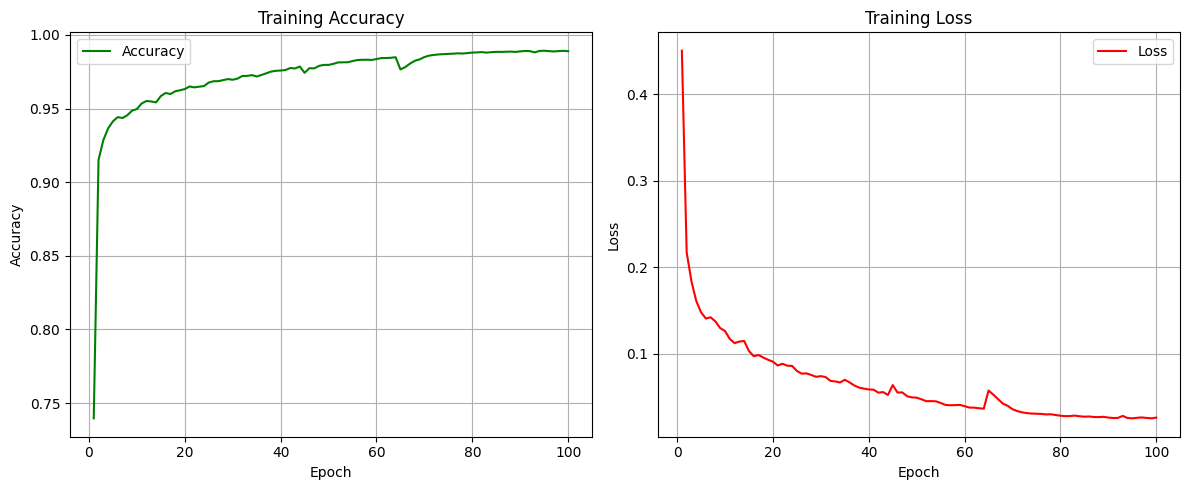

In [ ]:
# Tr√≠ch xu·∫•t d·ªØ li·ªáu t·ª´ l·ªãch s·ª≠ hu·∫•n luy·ªán
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(acc) + 1)

# V·∫Ω bi·ªÉu ƒë·ªì Accuracy v√† Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()

# L∆∞u h√¨nh ·∫£nh v√†o file PNG
plt.savefig('Gray_2750_acc_loss.png', dpi=300)

# Hi·ªÉn th·ªã bi·ªÉu ƒë·ªì
plt.show()


In [ ]:
# H√†m h·∫≠u x·ª≠ l√Ω b·∫±ng Morphological Operations
def apply_morphology(mask, kernel_size=3, iterations=1):
    """
    Morphological post-processing: closing -> opening ƒë·ªÉ lo·∫°i b·ªè nhi·ªÖu v√† l·ªó h·ªïng.
    - kernel_size: K√≠ch th∆∞·ªõc kernel (7).
    - iterations: S·ªë l·∫ßn √°p d·ª•ng ph√©p to√°n (1 or 2).
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    mask = (mask > 0.5).astype(np.uint8)  # Ng∆∞·ª°ng h√≥a tr∆∞·ªõc

    # Closing ƒë·ªÉ l·∫•p l·ªó h·ªïng nh·ªè
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    # Opening ƒë·ªÉ lo·∫°i b·ªè nhi·ªÖu
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=iterations)

    return opened.astype(np.float32)  # Chuy·ªÉn v·ªÅ float ƒë·ªÉ t√≠nh to√°n metrics

# ƒê√°nh gi√° m√¥ h√¨nh g·ªëc (kh√¥ng h·∫≠u x·ª≠ l√Ω)
print("üîç ƒê√°nh gi√° kh√¥ng h·∫≠u x·ª≠ l√Ω...")
results = segunet.evaluate(test_images_gray_clahe, test_masks, verbose=1)
loss, accuracy, jaccard = results
print(f"Kh√¥ng h·∫≠u x·ª≠ l√Ω - Dice Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%, Jaccard: {jaccard*100:.2f}%")

# D·ª± ƒëo√°n v√† h·∫≠u x·ª≠ l√Ω ch·ªâ v·ªõi Morphological Operations
print("\nüîß ƒê√°nh gi√° sau Morphology...")
predictions1 = segunet.predict(test_images_gray_clahe)
refined_predictions1 = []

for i in tqdm(range(len(test_images_gray_clahe))):
    pred = predictions1[i].squeeze()

    # √Åp d·ª•ng Morphological Operations
    morph_pred = apply_morphology(pred, kernel_size=7, iterations=2)

    refined_predictions1.append(morph_pred)

    # L∆∞u ·∫£nh m·∫´u ƒë·ªÉ so s√°nh
    # if i < 3:
    #     cv2.imwrite(f'before_morph_{i}.png', (pred > 0.5).astype(np.uint8) * 255)
    #     cv2.imwrite(f'after_morph_{i}.png', morph_pred * 255)

# Chuy·ªÉn sang numpy array v√† th√™m chi·ªÅu channel n·∫øu c·∫ßn
refined_predictions1 = np.expand_dims(np.array(refined_predictions1), axis=-1)

# T√≠nh to√°n metrics
accuracy_after = np_accuracy(test_masks, refined_predictions1)
jaccard_after = np_jaccard_coefficient(test_masks, refined_predictions1)
loss_after = np_dice_loss(test_masks, refined_predictions1)

print(f"Sau Morphology - Dice Loss: {loss_after:.4f}, Accuracy: {accuracy_after*100:.2f}%, Jaccard: {jaccard_after*100:.2f}%")

üîç ƒê√°nh gi√° kh√¥ng h·∫≠u x·ª≠ l√Ω...
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 153ms/step - accuracy: 0.9544 - jaccard_coefficient: 0.8024 - loss: 0.1119
Kh√¥ng h·∫≠u x·ª≠ l√Ω - Dice Loss: 0.1459, Accuracy: 94.99%, Jaccard: 75.09%

üîß ƒê√°nh gi√° sau Morphology...
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 150ms/step


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 825/825 [00:00<00:00, 1654.53it/s]


Sau Morphology - Dice Loss: 0.1314, Accuracy: 95.00%, Jaccard: 76.77%


In [ ]:
def apply_crf(original_image, model_output):
    """√Åp d·ª•ng CRF ƒë·ªÉ tinh ch·ªânh ph√¢n ƒëo·∫°n."""
    H, W = original_image.shape[:2]
    model_output = np.squeeze(model_output)
    probs = np.stack([1.0 - model_output, model_output], axis=0)

    d = dcrf.DenseCRF2D(W, H, 2)
    d.setUnaryEnergy(unary_from_softmax(probs))
    d.addPairwiseGaussian(sxy=3, compat=3)

    if len(original_image.shape) == 2:
        original_image = original_image[..., np.newaxis]
    if original_image.shape[-1] == 3:
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)[..., np.newaxis]

    pairwise_energy = create_pairwise_bilateral(sdims=(80, 80), schan=(13,), img=original_image.astype(np.uint8), chdim=2)
    d.addPairwiseEnergy(pairwise_energy, compat=10)

    Q = d.inference(10)
    return np.argmax(Q, axis=0).reshape((H, W))



# ƒê√°nh gi√° m√¥ h√¨nh
print("ƒê√°nh gi√° tr∆∞·ªõc CRF...")
results = segunet.evaluate(test_images_gray_clahe, test_masks, verbose=1)
loss, accuracy, jaccard = results
print(f"Tr∆∞·ªõc CRF - Dice Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%, Jaccard: {jaccard*100:.2f}%")

# √Åp d·ª•ng CRF v√† ƒë√°nh gi√°
print("\nƒê√°nh gi√° sau CRF...")
predictions2 = segunet.predict(test_images_gray_clahe)
refined_predictions2 = []

for i in range(len(test_images_gray_clahe)):
    img = test_images_gray_clahe[i]
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    refined_pred = apply_crf(img, predictions2[i])
    refined_predictions2.append(refined_pred)
    # if i < 3:
    #     cv2.imwrite(f'before_crf_{i}.png', (predictions[i] > 0.5).astype(np.uint8).squeeze() * 255)
    #     cv2.imwrite(f'after_crf_{i}.png', refined_pred * 255)

refined_predictions2 = np.array(refined_predictions2)
accuracy_after = np_accuracy(test_masks, refined_predictions2)
jaccard_after = np_jaccard_coefficient(test_masks, refined_predictions2)
loss_after = np_dice_loss(test_masks, refined_predictions2)

print(f"Sau CRF - Dice Loss: {loss_after:.4f}, Accuracy: {accuracy_after*100:.2f}%, Jaccard: {jaccard_after*100:.2f}%")

ƒê√°nh gi√° tr∆∞·ªõc CRF...
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 153ms/step - accuracy: 0.9544 - jaccard_coefficient: 0.8024 - loss: 0.1119
Tr∆∞·ªõc CRF - Dice Loss: 0.1459, Accuracy: 94.99%, Jaccard: 75.09%

ƒê√°nh gi√° sau CRF...
26/26 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 150ms/step
Sau CRF - Dice Loss: 0.1338, Accuracy: 94.96%, Jaccard: 76.40%


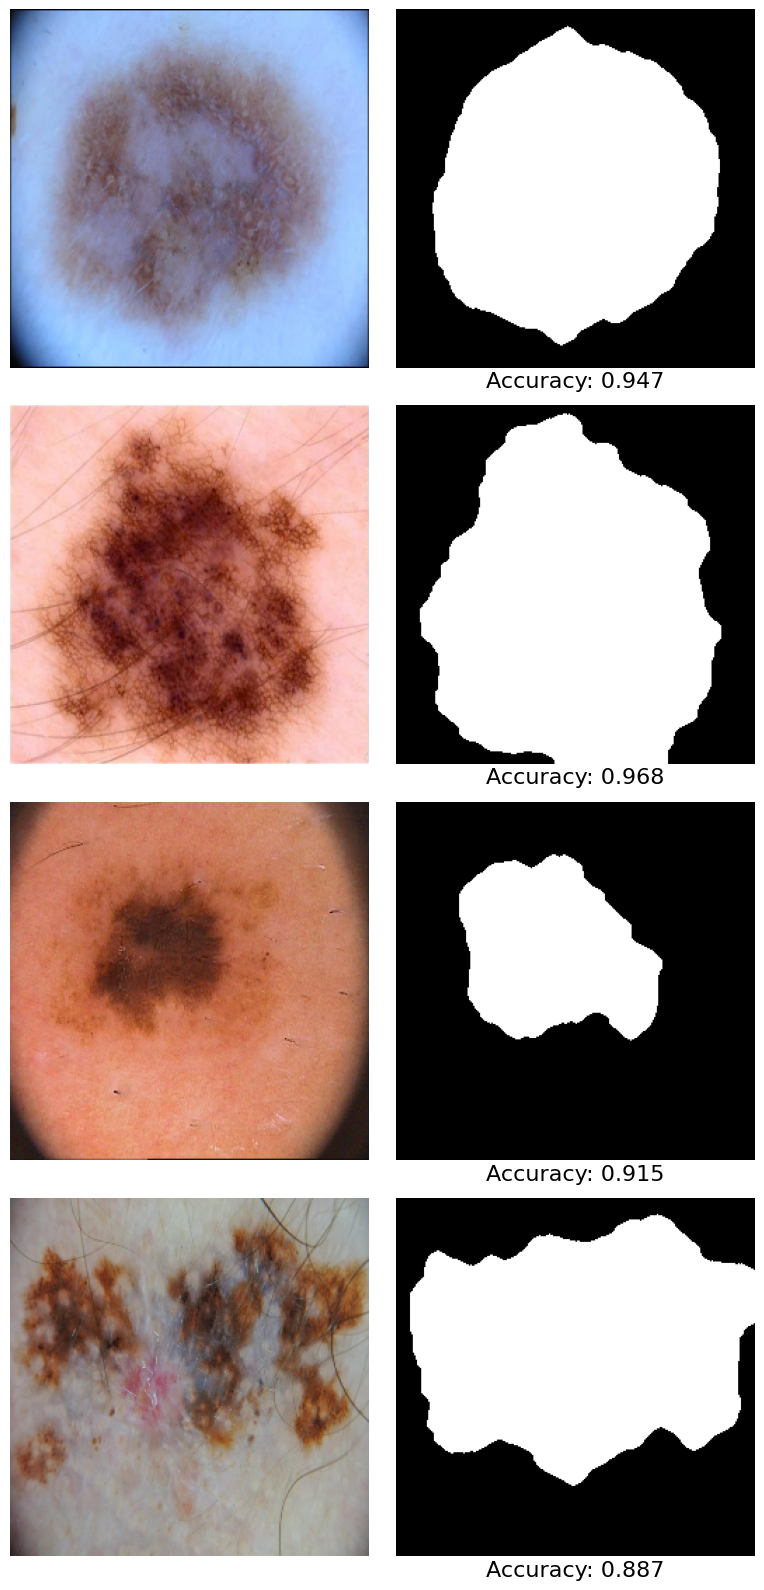

In [ ]:
def show_predictions_with_metrics_grid(refined_predictions1,
                                       images, masks,
                                       indices,
                                       save_path):

    num_images = len(indices)
    plt.figure(figsize=(8, 4 * num_images))  # 2 c·ªôt, num_images h√†ng

    for i, idx in enumerate(indices):
        image = images[idx]
        true_mask = masks[idx]
        pred_morph = refined_predictions1[idx]

        # Resize pred_morph v·ªÅ c√πng k√≠ch th∆∞·ªõc v·ªõi true_mask n·∫øu c·∫ßn
        if pred_morph.shape != true_mask.shape:
            pred_morph = cv2.resize(pred_morph, (true_mask.shape[1], true_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

        # T√≠nh metrics
        accuracy = np_accuracy(true_mask, pred_morph)

        # C·ªôt 1: ·∫¢nh g·ªëc
        ax1 = plt.subplot(num_images, 2, 2*i + 1)
        ax1.imshow(image)
        # ax1.set_title(f"·∫¢nh g·ªëc - idx {idx}", fontsize=14)
        ax1.axis('off')

        # C·ªôt 2: ·∫¢nh morphology + metrics
        ax2 = plt.subplot(num_images, 2, 2*i + 2)
        ax2.imshow(pred_morph, cmap='gray')
        # ax2.set_title("H·∫≠u x·ª≠ l√Ω Morphology", fontsize=14)
        ax2.axis('off')
        ax2.text(0.5, -0.01,
                 f"Accuracy: {accuracy:.3f}",
                 fontsize=16, ha='center', va='top', transform=ax2.transAxes)

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


show_predictions_with_metrics_grid(
    refined_predictions1=refined_predictions1,
    images=test_images,
    masks=test_masks,
    indices=[11, 44, 75, 123],  # 4 ·∫£nh
    save_path="/kaggle/working/gray2750.png"
)


In [ ]:
segunet.save('/kaggle/working/model/gray_2750_model.h5')
segunet.save('/kaggle/working/model/gray_2750_model.keras')